<a href="https://colab.research.google.com/github/MadmanMarble/GLAP/blob/main/Amanda_Lambert_MidTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mid Term Project
##Description of the mid term project: this project implements linear regression from scratch with stochastic gradient descent, without using a library function except of course the necessary functions for array processing and autograd. The given code implements linear regression with the MSE loss function and the assignment is to experiment with other loss functions.
***Notes***: The linear regression code for this notebook is based on ***3.2. Linear Regression Implementation from Scratch*** of the [Dive into Deep Learning Book](https://d2l.ai/index.html)

In [36]:
!pip install -U d2l

In [37]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


In [38]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # generating noise
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # 1000 is the number of the data points chosen

In [39]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.5460, 0.4887]) 
label: tensor([3.6133])


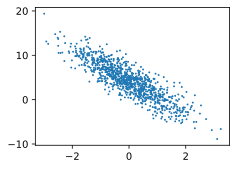

In [40]:
# lets plot the sythetic data that has been generated
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

In [41]:
# this is doing the selection
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [42]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.1751,  1.6717],
        [ 0.7052,  0.1450],
        [-0.3964,  0.1032],
        [ 0.9753,  0.2597],
        [ 2.5271,  1.2248],
        [ 0.6204,  0.2773],
        [ 1.0858,  0.4587],
        [ 0.1251, -0.8223],
        [ 0.4967,  2.1635],
        [-0.8357, -1.2142]]) 
 tensor([[-1.1406],
        [ 5.1204],
        [ 3.0405],
        [ 5.2582],
        [ 5.0918],
        [ 4.4884],
        [ 4.8060],
        [ 7.2565],
        [-2.1504],
        [ 6.6682]])


In [43]:
# our goal is to find the best values for w and b given the dataset that we have
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [44]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

In [45]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [46]:
# stocastic gradient descent
# the initial slope and intersept points could be random
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [47]:
lr = 0.1 # learning rate
num_epochs = 3 # the number of times you iterate
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000053
epoch 2, loss 0.000053
epoch 3, loss 0.000053


In [48]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 3.9816e-05, -8.3852e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0004], grad_fn=<RsubBackward1>)


#Assigned tasks:
##The MSE loss function is not the only loss function for linear regression. To be robust to outliers in the training data, the Huber loss and the Log-Cosh are used. Your task is to implement both loss functions in addition to the given MSE loss function (named squared_loss) of this notebook, and to compare their performance on data with outliers. The specific tasks are as follows -
1.   Add two more code cells - one that defines the Huber loss function, and another with defines the Log-Cosh. This [blog post](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0) describes these loss functions and provides code which is written in numpy so it will need to changed to compatible with PyTorch.
2.   Inject outliers in the data generated by the synthetic data generator of this notebook. You could add random noise to the existing data objects, i.e. changing a given percentage of the data entries to random values within the data range. Inclusion of these outliers will let you compare the benefits of these two loss functions against the MSE.
3.   Create a text cell to summarize your experimental observations as follows: (1) note how many outliers you added (2) compare the error in estimating w and b between MSE, Huber loss, and Log-Cosh loss.







In [49]:
# Define the Huber loss function using PyTorch
def huber_loss(y_pred, y_true, delta=1.0):
    error = y_true - y_pred
    abs_error = torch.abs(error)

    is_small_error = abs_error <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (abs_error - 0.5 * delta)

    return torch.where(is_small_error, squared_loss, linear_loss).mean()

In [50]:
def log_cosh_loss(y_pred, y_true):
    error = y_true - y_pred
    return torch.log(torch.cosh(error)).mean()

In [51]:
def inject_outliers(features, labels, percentage=0.05):
    num_outliers = int(percentage * len(labels))
    indices = torch.randperm(len(labels))[:num_outliers]
    labels[indices] += torch.normal(0, 10, size=labels[indices].shape)
    return labels

labels_with_outliers = inject_outliers(features, labels.clone(), percentage=0.05)

In [52]:
# Train the model with different loss functions
def train_model(loss_fn, num_epochs=3, lr=0.1):
    w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels_with_outliers):
            l = loss_fn(linreg(X, w, b), y)
            l.sum().backward()
            sgd([w, b], lr, batch_size)

        with torch.no_grad():
            train_l = loss_fn(linreg(features, w, b), labels_with_outliers)
            print(f'Epoch {epoch + 1}, Loss: {float(train_l.mean()):f}')

    print(f'Error in estimating w: {true_w - w.reshape(true_w.shape)}')
    print(f'Error in estimating b: {true_b - b}')

# Train and compare models using different loss functions
print("MSE Loss:")
train_model(squared_loss) # provided in notebook
print("\nHuber Loss:")
train_model(huber_loss)
print("\nLog-Cosh Loss:")
train_model(log_cosh_loss)

MSE Loss:
Epoch 1, Loss: 2.136390
Epoch 2, Loss: 2.172949
Epoch 3, Loss: 2.134608
Error in estimating w: tensor([ 0.1511, -0.2427], grad_fn=<SubBackward0>)
Error in estimating b: tensor([0.0067], grad_fn=<RsubBackward1>)

Huber Loss:
Epoch 1, Loss: 3.855712
Epoch 2, Loss: 3.187465
Epoch 3, Loss: 2.539958
Error in estimating w: tensor([ 1.2545, -2.1022], grad_fn=<SubBackward0>)
Error in estimating b: tensor([2.2465], grad_fn=<RsubBackward1>)

Log-Cosh Loss:
Epoch 1, Loss: 3.712599
Epoch 2, Loss: 3.057070
Epoch 3, Loss: 2.427530
Error in estimating w: tensor([ 1.2803, -2.1246], grad_fn=<SubBackward0>)
Error in estimating b: tensor([2.2766], grad_fn=<RsubBackward1>)


**Summary**

---
I added 5% outliers into the data by adding random noise. I compared the performance between MSE loss, Huber loss, and Log-Cosh loss. I set the number of epochs to 3 and set the learning rate to 0.1. The MSE loss is the least robut of the three loss functions. Huber loss and Log-Cosh loss are effective at decreasing the loss value but show results of high error in weights and bias estimates. Overall, Huber loss and Log-Cosh loss are more equipt at handeling data with outliers than MSE loss. MSE loss resulted in the lowest eorros for weights and bias estimates.  


#Assigned tasks:
##This is not a coding task. Create a text cell below this cell, go through the Jake VDP linear regression notebook and write in your own words (2 -3 paragraphs):


*   Different regression techniques presented in the notebook.
*   Think of a problem similar to predicting bicycle traffic and describe how you would solve it with regression.









The Jake VDP notebook covered a few regression techniques. First, simple linear regiression, which fits a straight line to the data, is presented. Scikit-Learn's linear regression used to fine the best-fit line for single and multi-dimensional models is discussed. It also covers basis function regression, including polynomial regression. Gaussian basis functions are discussed. Next, the notebook discusses the use of regularization techniques, those being L2 and L1. Ridge regression (L2 regularization) and Lasso regression (L1 regularization) both are used to help prevent overfitting by penalizing hte size of model coefficients.



---

A similar problem to the one presented here about bicycle traffic data could be using linear regression to predict movie box office revenue. This would be a multiple linear regression problem because there are multiple variables that infuence the revenue. To solve this problem I would list the independent variables:
1. Budget: The amount spent to produce the movie. Higher quality production movies could correlate with higher revenue.
2. Release date: Movies release during certian time periods may perform better than other time periods due to more attendance.
3. Popularity: The name recognition of the director, actors, etc. may attact more audience leading to higher revenue.
4. Genre: Different genres perform differently in theaters. Action movies might have higher revenue than horror movies.

The model could be improved by including more features and data sources such as time series data. This could show changes in audiences behavior over time. Changes in preferences could impact movie sales and revenue. Also, marketing's effectiveness to influence audiences to see the movie could provide insights into movie sales and revenue. I would also inclue demographic information about audiences viewership. There's a lot of variables that could be added to this, but starting here would be provide an introductory method of viewing which of these factors influence movie box office revenues.